## Spooky Spooky Exploration

An analysis revolving around Intelligibility

By Nick Brooks

In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import nltk
import random

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as plt

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# N- Grams
from nltk.util import ngrams
from collections import Counter

# Topic Modeling
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Word 2 Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Models
import datetime
from nltk import naivebayes

import warnings
warnings.filterwarnings("ignore")

D:\WindowsApps\Anaconda\envs\tensorflow\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
D:\WindowsApps\Anaconda\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Goal:

Attempt to understand the themes and style of each author using statistical methods, instead of reading the books like a normal person..


## Introduction:

This dataset is comprised of authors who mostly lived in the 19ths century. Earliest of the bunch, Mary Shelley is most famous for her work Frankenstein. Her Gothic Horror style refers to the architectural setting of her stories, which is an iconic style of the medieval era. I can easily imagine a dark stone castle in the night being confronted by a angry mob of villagers with torches and pitchforks! Through this environment, Shelley also explores the contemporary themes of the role of the individual in a secular government, carrying Locke and Rousseau’s burden into the world of fiction.
Although Edgar Allan Poe is also known of residing in the realm of Gothic Horror, his writing is perhaps more centered around an urban setting. Furthermore, while Shelley resided in England and Europe, Poe was a Bostonian who was orphaned at an early age, and lacked the funds and parental guidance of Shelley.
H.P Lovecraft, our final member of the Spooky club, also lived his life in the American Northeast. Similar to Poe, he also struggled to support himself as an author, and his health took a serious toll because of it. Lovecraft's early work is said to be influenced by Poe’s Macabre style. However, in the end, Lovecraft’s obsession with Astronomy led him to center his stories in a cosmic setting, exploring themes of human insignificance amongst ancient gods and prophecies. Do you hear its Call?

So what?
This brief introduction of the author’s artistic style indicate that there is a lot of overlap in terms of the setting and influence between these three authors. It would be interesting to test the integrity of this hypothesis by analysing the unsupervised technique of word vector of themes such as: Astronomy, Medieval Ages, Gods, Nihilism, Life. 


In [2]:
import sys
sys.version

'3.5.4 |Anaconda custom (64-bit)| (default, Aug 14 2017, 13:41:13) [MSC v.1900 64 bit (AMD64)]'

In [3]:
# Read Data
os.chdir(r"C:\Users\Nicol\Google Drive\Learning\Jupyter\Data\spooky")
df = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")
# df = pd.read_csv("../input/train.csv", index_col="id")
# test = pd.read_csv("../input/test.csv", index_col="id")

In [4]:
pd.set_option('max_colwidth', 500)
df.text= df.text.astype(str)
df.author = pd.Categorical(df.author)
df.iloc[:20,:]

,text,author
id,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL
id22965,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",MWS
id09674,"The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.",EAP
id13515,The surcingle hung in ribands from my body.,EAP
id19322,"I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could not avoid casting your eyes upward to the great nebula in Orion, and I certainly expected that you would do so.",EAP


## First look at sentence samples:
Wow, these sentences sure are Spooky. Except for the last of the bunch, where Lovecraft comments on the mature look of a chinless child. From these samples so far, the writing style definitely seems drawn out and convoluted. Something a modern like me is not completely accustomed to..


## Pre-Processing

- Lexicon Processing and Normalization
- Lowercasing and Removing Punctuation
- Tokenization
- Removing Stopwords


In [5]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #ords = [ps.stem(w) for w in words] #4
    return words

def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)

## Sentiment Analysis

I am hoping to get an idea of the general mood of each author. Understanding the mood could potentially point to the most “macabre” of them all.

In [6]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()

# Applying Model, Variable Creation
sentiment = df.copy()
sentiment['polarity_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['compound'])
sentiment['neutral_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['neu'])
sentiment['negative_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['neg'])
sentiment['positive_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['pos'])
sentiment['sentiment']=''
sentiment.loc[sentiment.polarity_score>0,'sentiment']='POSITIVE'
sentiment.loc[sentiment.polarity_score==0,'sentiment']='NEUTRAL'
sentiment.loc[sentiment.polarity_score<0,'sentiment']='NEGATIVE'

# Normalize for Size
auth_sent= sentiment.groupby(['author','sentiment'])[['text']].count().reset_index()
for x in ['EAP','HPL','MWS']:
    auth_sent.text[auth_sent.author == x] = (auth_sent.text[auth_sent.author == x]/\
        auth_sent[auth_sent.author ==x].text.sum())*100

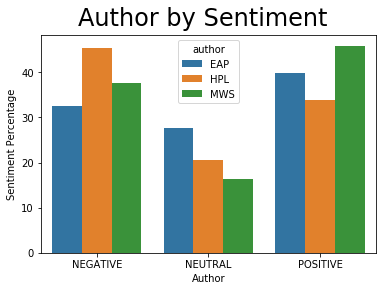

In [7]:
ax= sns.barplot(x='sentiment', y='text',hue='author',data=auth_sent)
ax.set(xlabel='Author', ylabel='Sentiment Percentage')
ax.figure.suptitle("Author by Sentiment", fontsize = 24)
plt.show()

After normalizing for sentence size by author, I am surprised to find that Lovecraft is the most negative writer, and that Shelley is the most polarized, with the least amount of neutral sentences. This suggests a high volatility between sentences, an author not afraid of taking her readers through a rollercoaster of emotions.

After reading each author’s wikipedia page, I was really expecting Poe to top the negativity chart, since his writing seemed centered around bleak city streets. Now that I think about it, there isn’t anything too cheerful about the evil space squids, Cthulhu.


## WordCloud

Word clouds are great at shedding light on the author’s prefered language.

In [8]:
# Function
def cloud(text, title):
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
    #mpl.rcParams['font.size']=12                #10 
    mpl.rcParams['savefig.dpi']=100             #72 
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    stopwords = set(STOPWORDS) # Redundant
    wordcloud = WordCloud(width=1400, height=800,
                          background_color='black',
                          #stopwords=stopwords,
                         ).generate(" ".join(text))
    
    # Output Visualization
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=50,color='y')
    #plt.imshow(plt.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    #fig.savefig("wordcloud.png", dpi=900)

None


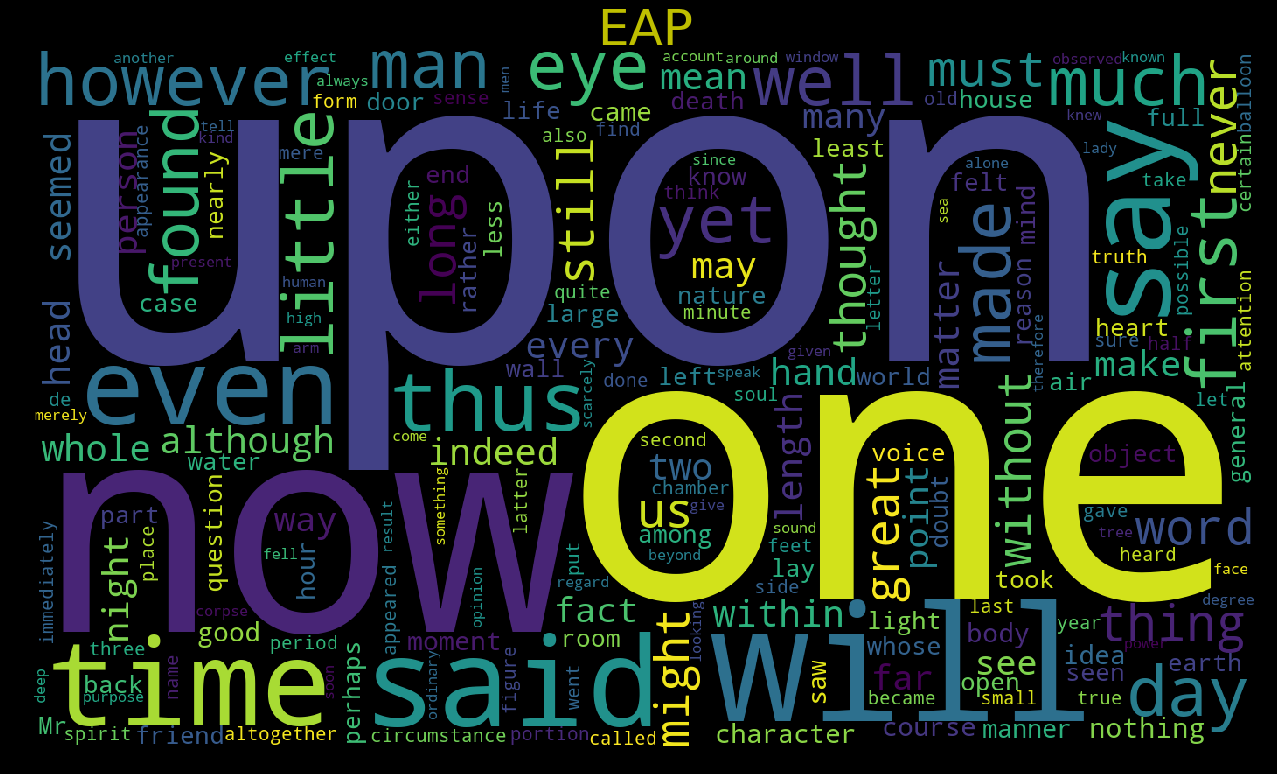

In [9]:
x = "EAP"
print(cloud(df[df.author == x]['text'].values,x))

This word cloud brings to light some of the propositional words, as well as some simple vocabulary. Unfortunately, the most defining characteristics of Poe do not emerge.

None


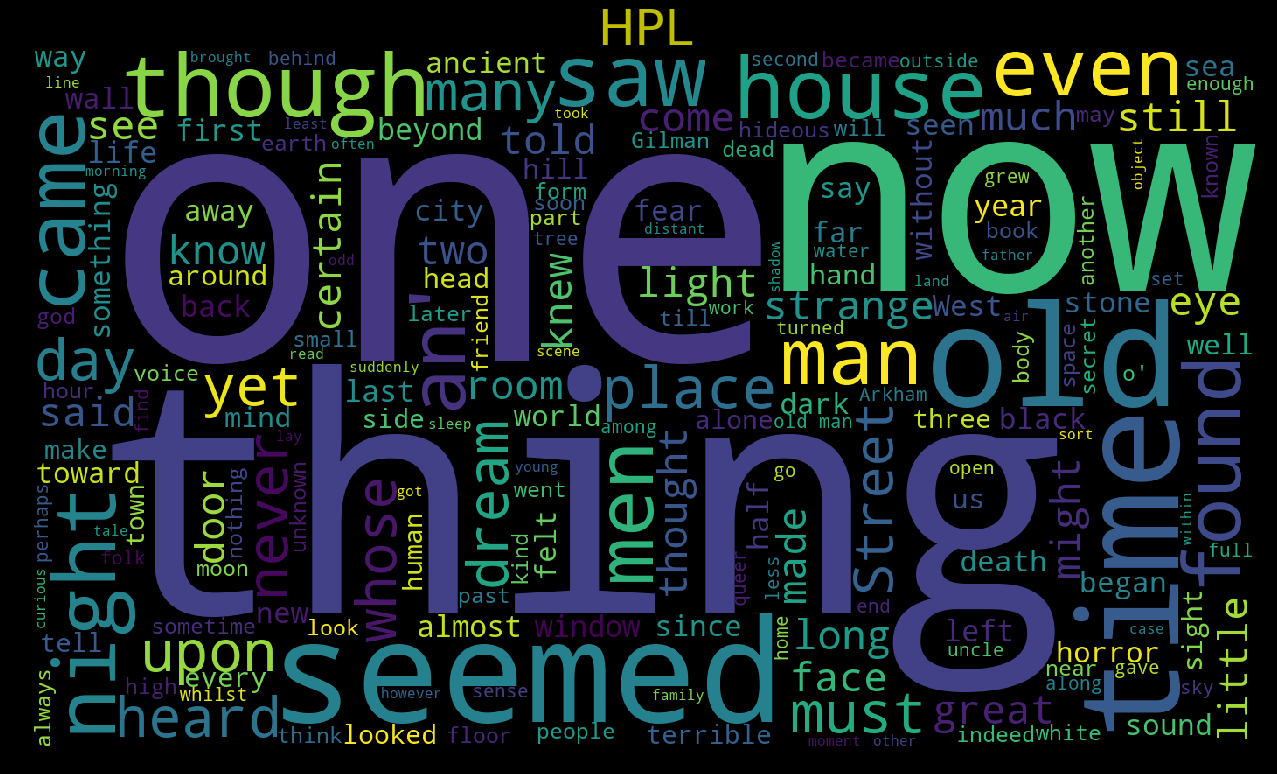

In [10]:
x = "HPL"
print(cloud(df[df.author == x]['text'].values,x))

"Seemed", "Thing", "Old", "Night" are words I would expect in the Lovecraft mythos.

None


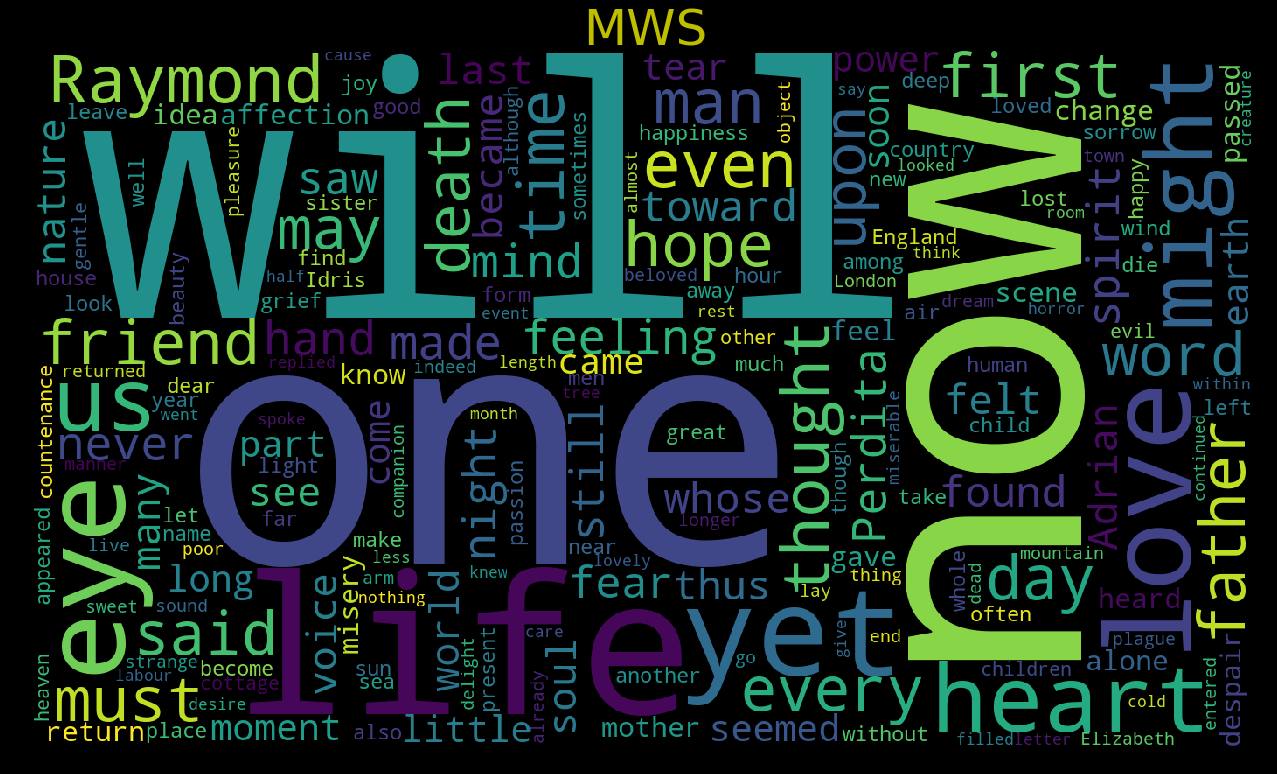

In [11]:
x = "MWS"
print(cloud(df[df.author == x]['text'].values,x))

My suspicions that Shelley would focus on existential themes is correct. “Life”, “heart”, “love”, “soul”, “death” seem right out of Frankenstein. Unfortunately, the dataset does not indicate the novels included.

## N Grams

Another tool leveraging statistical frequency.. N-Grams! This method finds the most common sequence of words by N length. While the word cloud has a sequence length of 1, N-Grams may provide insight into the prose of the author.

In [12]:
## Helper Functions
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(x, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(df[df.author == x]['text']),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurence"]
        out = pd.concat([out, table], axis=1)
    return out

#### Edgar Allan Poe

Mr. Crab? (#13 on 2-Gram), did a Spongebob text sample get sneaked in here? Interestingly, 2-Grams has a few French words such as “L’etoile”, and “Espanaye”. Other than that, “ha ha” also stands out, since I was under the impression that this was unique to millennial texting.

In terms of 3-Grams, this sequence length gives a good idea of some of the major characters and locations.

Finally, 4-Grams also give insight in some strange sayings, like “ugh ugh ugh ugh”, and “mille mille mille mille” which is just four times “thousand” in French.

In [13]:
gram_table(x="EAP", gram=[1,2,3,4], length=20)

,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence
0,upon,1025,let us,50,general john b,12,general john b c,12
1,one,655,one two,23,madame l espanaye,12,brigadier general john b,7
2,could,453,l etoile,23,john b c,12,ugh ugh ugh ugh,6
3,would,409,three four,23,ha ha ha,11,john b c smith,6
4,said,356,every thing,22,barrière du roule,10,brevet brigadier general john,6
5,little,275,ha ha,22,ugh ugh ugh,8,angle forty five degrees,5
6,say,267,main compartment,21,de l omelette,7,nice relations size proportion,4
7,well,265,said dupin,21,mille mille mille,7,detecting bringing practice nice,4
8,made,263,old man,21,brigadier general john,7,doctor dubble l dee,4
9,even,261,looked upon,20,forty five degrees,7,hum drum rowdy dow,4


#### HP Lovecraft

“Heh heh heh heh..” said the old women small furry. Lovecraft’s N-Grams could have its own Card Against Humanities edition. His N-Grams give a good amount of insight on his characters and iconic objects, such as the necronomicon, and a slew of characters with strange, ominous features.


In [14]:
gram_table(x="HPL", gram=[1,2,3,4], length=20)

,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence
0,one,491,old man,59,terrible old man,9,oonai city lutes dancing,4
1,could,480,could see,31,heh heh heh,9,aira city marble beryl,4
2,old,392,one night,23,small paned windows,8,eric moreland clapham lee,4
3,would,357,old woman,21,charles le sorcier,8,mad arab abdul alhazred,4
4,man,280,one might,18,great great great,6,necronomicon mad arab abdul,4
5,like,273,heh heh,17,cap n obed,5,heh heh heh heh,3
6,seemed,272,shunned house,17,city marble beryl,5,village plain edge bog,3
7,night,255,one could,17,small furry thing,4,sir eric moreland clapham,3
8,time,238,could tell,16,sea meets sky,4,regions sea meets sky,3
9,things,238,new england,16,small hours morning,4,great great great grandfather,3


#### Mary Shelley

The theme of life and mortality is not evident in much of the higher N-Grams. It is interesting to note that the occurrences of 3 and 4 Grams are very low, suggesting that Shelley does not make use of drawn out phrases. 


In [15]:
gram_table(x="MWS", gram=[1,2,3,4], length=20)

,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence
0,one,477,old man,29,let us go,4,one day may claim,2
1,would,475,lord raymond,28,months elapsed since,3,like thousand packs wolves,2
2,could,383,fellow creatures,22,first rank among,3,five years old mother,2
3,life,334,one day,20,five years old,3,nothing painful human mind,2
4,yet,318,let us,16,became every day,3,next day next hour,2
5,love,274,every day,15,hundred thousand years,3,day may claim hands,2
6,us,272,native country,14,nearly two years,3,nearest town took post,2
7,raymond,270,taken place,14,whole human race,3,hope good passion guilt,1
8,might,269,years age,12,time lord raymond,3,blue eyes angelic girl,1
9,heart,265,first time,12,might one day,3,moments shall curse maker,1


#### N-Gram conclusion

Within this genre of horror, there seems to be a strange interest in “old man”.


## Unsupervised Learning/ Topic Modeling

My next goal is to try to use more advanced methods to extract some of the themes, or topics within each author. 

## Latent Dirichlet Allocation
*Full Credit goes to Anisotropic! Check out his amazing notebook*. I was very impressed by his analysis and wanted to see if topics could be applied within each author.

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

The LDA model uses probability to output the top words of each cluster.

In [16]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
    
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)
    
def LDA(data):
    # Storing the entire training text in a list
    text = list(data.values)
    # Calling our overwritten Count vectorizer
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2,
                                              stop_words='english',
                                              decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)


    lda = LatentDirichletAllocation(n_topics=6, max_iter=5,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)

    lda.fit(tf)

    n_top_words = 10
    print("\nTopics in LDA model: ")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)

#### Edgar Allan Poe

In [17]:
x = "EAP"
LDA(df.text[df.author==x])


Topics in LDA model: 

Topic #0:door house open room tree wall clock light window position

Topic #1:reason sense tell entered death car lady life year existence

Topic #2:day let fact long like far came body thing thought

Topic #3:time said say mr did great man mind word make

Topic #4:eye head sure right black long know lost having turned

Topic #5:nature thing possible course case certain man face point hand


To me, topic #1 seems the most interesting since it suggest some kind of existential theme.


#### Mary Shelley

In [18]:
x = "MWS"
LDA(df.text[df.author==x])


Topics in LDA model: 

Topic #0:idea eye month perdita voice countenance away look appeared mind

Topic #1:mother raymond adrian friend sister city gave hand dear idris

Topic #2:love hope eye time heart shall death did thought feeling

Topic #3:life father year fear let men near felt time world

Topic #4:nature life human form sound resolved youth come step felt

Topic #5:day night sun country passed earth like wind cottage wood


Words such as "Love", "Life", "Hope" reinforce the observations made from the N-Grams and my prior assumptions about Shelley's themes.

#### HP Lovecraft

In [19]:
x = "HPL"
LDA(df.text[df.author==x])


Topics in LDA model: 

Topic #0:little face hand reason form life mansion escape shadow rat

Topic #1:room floor house held heavy gilman quality force object time

Topic #2:old thing told time great street men house man saw

Topic #3:day like night light man dream friend come came saw

Topic #4:case impression body result gave new dead shoulder claw april

Topic #5:ye thing like child place story better time folk say


Mostly setting centric topics.

## Word 2 Vec

In [20]:
def model_prep(df_in):
    df_in['tokenized'] = df_in.text.astype(str).str.lower() # turn into lower case text
    df_in['tokenized'] = df_in.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # apply tokenize to each row
    df_in['tokenized'] = df_in['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # remove stopwords from each row
    #df_in['tokenized'] = df_in['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # apply stemming to each row
    return df_in

def w2vec(data,yrange):
    wvec = model_prep(data)
    model = Word2Vec(data.tokenized, min_count=1, max_vocab_size=250)
    # model.save('model.bin')
    # new_model = Word2Vec.load('model.bin')
    
    # summarize the loaded model
    print(model)

    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    # create a scatter plot of the projection
    plt.rcParams["figure.figsize"] = [16,9]

    plt.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.ylim(yrange)   

    plt.show()
    


Word2Vec(vocab=137, size=100, alpha=0.025)


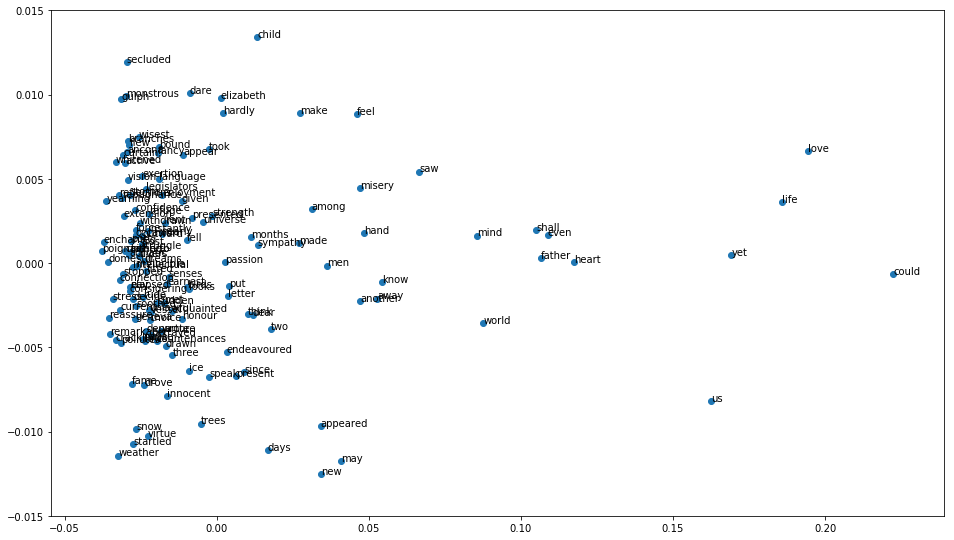

In [21]:
x = "MWS"
w2vec(df[df.author==x],[-.015,.015])


 EAP
Word2Vec(vocab=29, size=100, alpha=0.025)


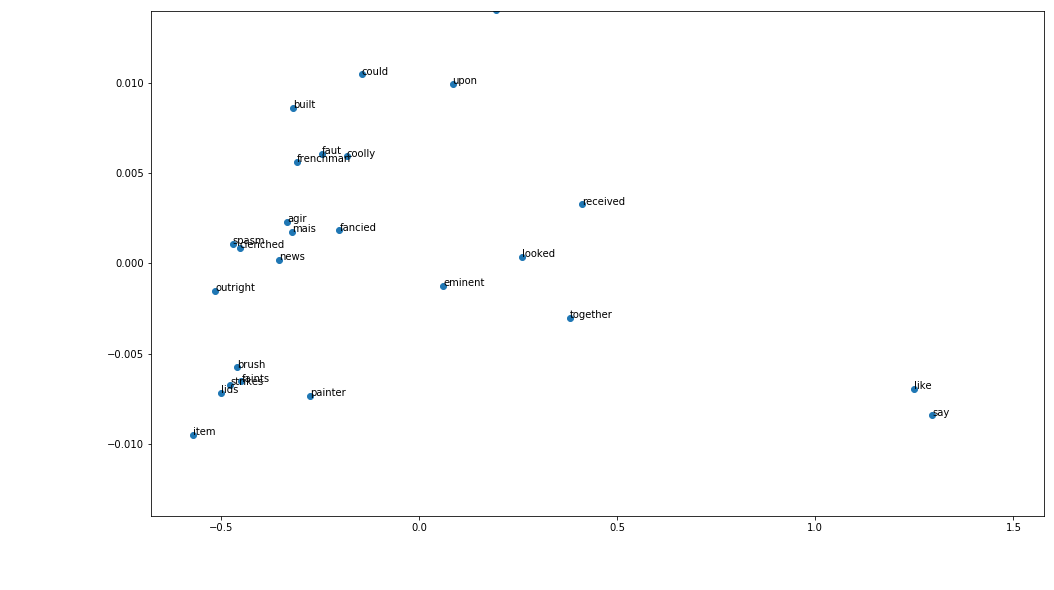

In [22]:
x = "EAP"
print("\n",x)
w2vec(df[df.author==x],[-.014,.014])


 HPL
Word2Vec(vocab=110, size=100, alpha=0.025)


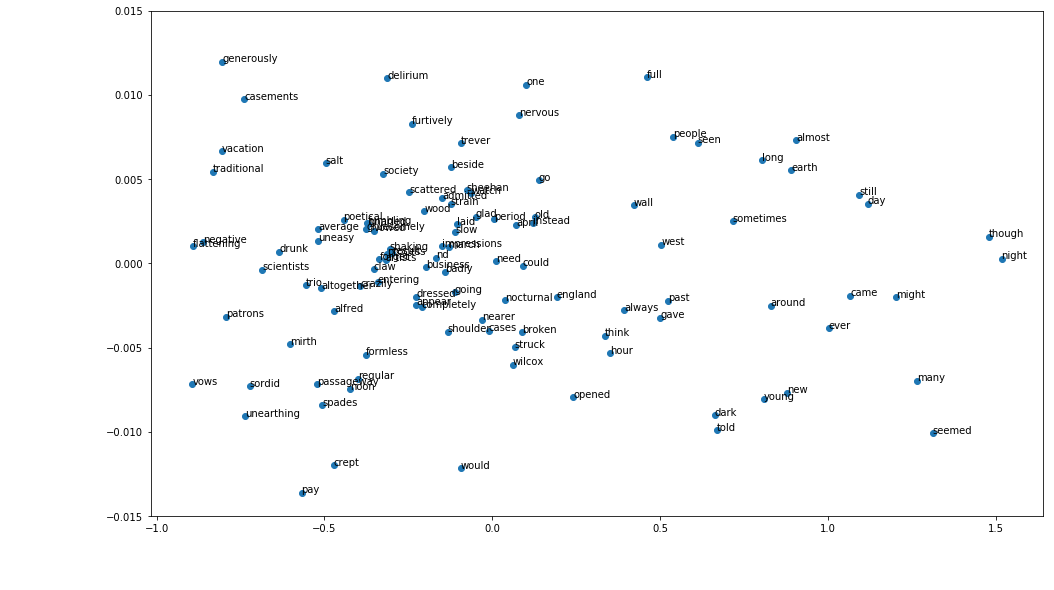

In [23]:
x = "HPL"
print("\n",x)
w2vec(df[df.author==x],[-.015,.015])

## Naive Bayes

Generative Models based off Bayes' Rule and Conditional Probabilities

In [24]:
print("Train Vocabulary Size: {}".format(len(nltk.FreqDist(preprocessing(df['text'])))))
print("Train Size: {}".format(len(df)))
print("Test Vocabulary Size: {}".format(len(nltk.FreqDist(preprocessing(test['text'])))))
print("Test Size: {}".format(len(test)))

Train Vocabulary Size: 24944
Train Size: 19579
Test Vocabulary Size: 17421
Test Size: 8392


In [25]:
# Number of features
all_words = nltk.FreqDist(preprocessing(df['text'])) # Calculate word occurence from whole block of text
word_features = list(all_words.keys())[:20000] 
# Number of columns (can't exceed vocab, only shrink it) from largest to smallest

# Helper Functions
# for each review, records which uniqeue words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Function to create model features
def model_prep(state, df_in):
    df_in['tokenized'] = df_in.text.astype(str).str.lower() # turn into lower case text
    df_in['tokenized'] = df_in.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # apply tokenize to each row
    df_in['tokenized'] = df_in['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # remove stopwords from each row
    df_in['tokenized'] = df_in['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # apply stemming to each row
    if state == "Train":
        print("{} Word Features: {}".format(state, len(word_features)))
        print("All Possible words in {} set: {}".format(state, len(all_words)))
        # Bag of Words with Label
        featuresets = [(find_features(text), LABEL) for (text, LABEL) in list(zip(df_in.tokenized, (df_in.author)))]
        print("Train Set Size: {}".format(len(featuresets)))
        print("Train Set Ready")
        return featuresets, word_features
    else:
        # Bag of Words without Labels
        featuresets = [(find_features(text)) for (text) in list(df_in.tokenized)]
        print("Submission Set Size: {}".format(len(featuresets)))
        print("Submission Set Ready")
        return featuresets

In [26]:
trainset, word_features= model_prep("Train", df_in=df)

Train Word Features: 20000
All Possible words in Train set: 24944
Train Set Size: 19579
Train Set Ready


In [27]:
submissionset = model_prep("Test", df_in=test)

Submission Set Size: 8392
Submission Set Ready


In [28]:
training_set = trainset[:15000]
testing_set = trainset[15000:]
del trainset

## Execute Model

In [29]:
start = time.time()
classifier = nltk.NaiveBayesClassifier.train(training_set)
# Posterior = prior_occurence * likelihood / evidence
end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

Model took 374.25 seconds to train


In [30]:
# Edgar Allan Poe [EAP], Mary Shelley[MWS], and HP Lovecraft[HPL]

In [31]:
print("Classifier Test Accuracy:",(nltk.classify.accuracy(classifier, testing_set))*100)
print(classifier.show_most_informative_features(40))

Classifier Test Accuracy: 76.21751474120987
Most Informative Features
                 raymond = True              MWS : HPL    =     72.8 : 1.0
                 passion = True              MWS : HPL    =     52.7 : 1.0
                   beard = True              HPL : EAP    =     41.5 : 1.0
                    grey = True              HPL : EAP    =     33.1 : 1.0
                  legend = True              HPL : EAP    =     32.2 : 1.0
                       l = True              EAP : MWS    =     31.3 : 1.0
                  jermyn = True              HPL : EAP    =     31.2 : 1.0
                    dear = True              MWS : HPL    =     29.8 : 1.0
                 balloon = True              EAP : HPL    =     26.5 : 1.0
                    girl = True              MWS : HPL    =     25.9 : 1.0
               endeavour = True              MWS : HPL    =     25.6 : 1.0
                   climb = True              HPL : EAP    =     24.7 : 1.0
                   grief = Tru

In [32]:
classifier.labels()

['EAP', 'MWS', 'HPL']

In [33]:
labels = classifier.labels()
submission = pd.DataFrame(columns=labels)
for x in submissionset:
    dist = classifier.prob_classify(x)
    submission= submission.append({labels[0]:dist.prob(labels[0]),
                                   labels[1]:dist.prob(labels[1]),
                                   labels[2]:dist.prob(labels[2])},ignore_index=True)
submission["id"] = test.index
submission= submission[["id", "EAP","HPL","MWS"]]

In [34]:
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.002785,0.002945,0.994270
1,id24541,0.399122,0.548061,0.052816
2,id00134,0.808394,0.191511,0.000095
3,id27757,0.479235,0.520633,0.000132
4,id04081,0.911563,0.045758,0.042679


In [35]:
# submission.to_csv("naive_spooky.csv", index=False)